## 1. Import package

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Because dataset.py is in the previous directory

import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern
from dataset import create_dataloaders
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## 2. Load data and convert to grayscale image (for traditional methods)

In [4]:
# Loading data
train_loader, val_loader, test_loader, class_names = create_dataloaders(
    root_dir='Aerial_Landscapes',
    batch_size=32,
    augmentation_strategy='minimal',
    num_workers=0
)

# Convert image to grayscale numpy format
def extract_numpy_images(dataloader):
    images, labels = [], []
    for batch_imgs, batch_labels in dataloader:
        for img, label in zip(batch_imgs, batch_labels):
            img_pil = TF.to_pil_image(img).convert("L")
            img_np = np.array(img_pil)
            images.append(img_np)
            labels.append(label.item())
    return np.array(images), np.array(labels)

X_train_imgs, y_train = extract_numpy_images(train_loader)
X_test_imgs, y_test = extract_numpy_images(test_loader)

创建数据加载器，batch_size=32, split_ratio=[0.6, 0.2, 0.2], augmentation=minimal...
数据集大小 - 训练: 7200, 验证: 2400, 测试: 2400
训练集类别分布:
- Agriculture: 480张图像
- Airport: 480张图像
- Beach: 480张图像
- City: 480张图像
- Desert: 480张图像
- Forest: 480张图像
- Grassland: 480张图像
- Highway: 480张图像
- Lake: 480张图像
- Mountain: 480张图像
- Parking: 480张图像
- Port: 480张图像
- Railway: 480张图像
- Residential: 480张图像
- River: 480张图像


## 3. Feature extraction function (supports HOG and LBP)

In [6]:
def extract_features(images, method='HOG'):
    features = []
    for img in images:
        if method == 'HOG':
            feat = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        elif method == 'LBP':
            lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
            feat = hist / np.sum(hist)
        features.append(feat)
    return np.array(features)

## 4. Define train and evaluate function

In [8]:
results = []

def train_and_evaluate(X_train, y_train, X_test, y_test, model, model_name):
    print(f"\n==== Model: {model_name} ====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

     # Evaluation Indicators
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Save the results for result graphs
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })
    # result
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print()
    
    #zero_division=0/1,	quickly suppress warnings
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=1))
    
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=class_names,
        xticks_rotation=90,
        cmap='Blues'
    )
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

## 5. Run four model combinations separately

### 5.1 HOG + SVM


==== Model: HOG + SVM(tuned) ====
Accuracy:  0.4146
Precision: 0.4144
Recall:    0.4146
F1-score:  0.4095

              precision    recall  f1-score   support

 Agriculture       0.32      0.36      0.34       160
     Airport       0.25      0.29      0.27       160
       Beach       0.44      0.35      0.39       160
        City       0.20      0.23      0.21       160
      Desert       0.50      0.43      0.46       160
      Forest       0.52      0.78      0.62       160
   Grassland       0.87      0.63      0.73       160
     Highway       0.41      0.40      0.41       160
        Lake       0.75      0.89      0.81       160
    Mountain       0.27      0.31      0.29       160
     Parking       0.37      0.32      0.34       160
        Port       0.48      0.51      0.49       160
     Railway       0.46      0.42      0.44       160
 Residential       0.24      0.21      0.22       160
       River       0.15      0.09      0.11       160

    accuracy              

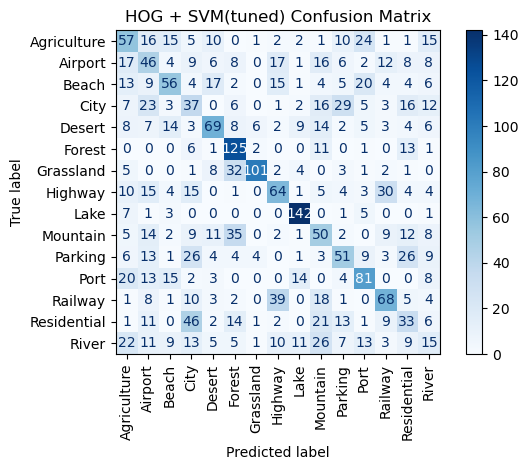

Best parameters: {'C': 10, 'kernel': 'rbf'}


In [11]:
X_train_hog = extract_features(X_train_imgs, method='HOG')
X_test_hog = extract_features(X_test_imgs, method='HOG')

#Find the best parameter model
svm_hog = GridSearchCV(SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}, cv=3, scoring='f1_weighted')
train_and_evaluate(X_train_hog, y_train, X_test_hog, y_test, svm_hog, "HOG + SVM(tuned)")
print("Best parameters:", svm_hog.best_params_)

### 5.2 HOG + KNN


==== Model: HOG + KNN (tuned) ====
Accuracy:  0.1258
Precision: 0.2722
Recall:    0.1258
F1-score:  0.0912

              precision    recall  f1-score   support

 Agriculture       0.00      0.00      0.00       160
     Airport       0.44      0.03      0.05       160
       Beach       0.55      0.04      0.07       160
        City       0.00      0.00      0.00       160
      Desert       0.27      0.14      0.19       160
      Forest       0.08      0.97      0.15       160
   Grassland       0.24      0.34      0.28       160
     Highway       0.18      0.01      0.02       160
        Lake       0.97      0.22      0.36       160
    Mountain       0.03      0.01      0.01       160
     Parking       0.57      0.03      0.05       160
        Port       1.00      0.00      0.00       160
     Railway       0.75      0.11      0.20       160
 Residential       1.00      0.00      0.00       160
       River       1.00      0.00      0.00       160

    accuracy             

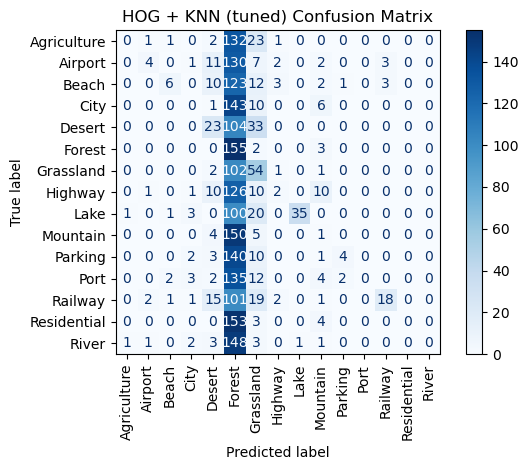

Best parameters: {'n_neighbors': 3}


In [13]:
knn_hog = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=3, scoring='f1_weighted')
train_and_evaluate(X_train_hog, y_train, X_test_hog, y_test, knn_hog, "HOG + KNN (tuned)")
print("Best parameters:", knn_hog.best_params_)

### 5.3 LBP + SVM


==== Model: LBP + SVM (tuned) ====
Accuracy:  0.4033
Precision: 0.4040
Recall:    0.4033
F1-score:  0.3875

              precision    recall  f1-score   support

 Agriculture       0.32      0.47      0.38       160
     Airport       0.26      0.31      0.28       160
       Beach       0.36      0.24      0.29       160
        City       0.17      0.24      0.20       160
      Desert       0.58      0.37      0.45       160
      Forest       0.61      0.82      0.70       160
   Grassland       0.72      0.71      0.71       160
     Highway       0.18      0.01      0.02       160
        Lake       0.68      0.39      0.49       160
    Mountain       0.37      0.36      0.37       160
     Parking       0.38      0.42      0.40       160
        Port       0.62      0.79      0.69       160
     Railway       0.30      0.39      0.34       160
 Residential       0.28      0.42      0.34       160
       River       0.23      0.11      0.15       160

    accuracy             

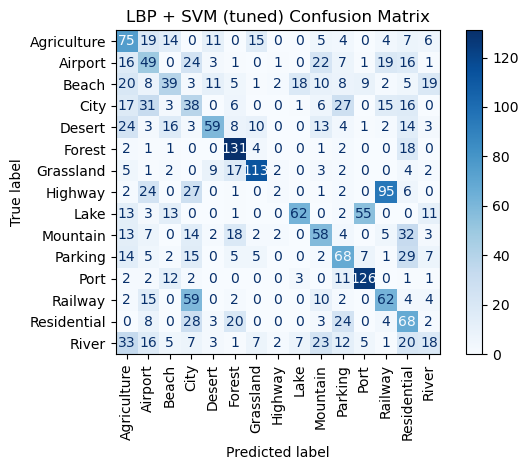

Best parameters: {'C': 10, 'kernel': 'rbf'}


In [15]:
X_train_lbp = extract_features(X_train_imgs, method='LBP')
X_test_lbp = extract_features(X_test_imgs, method='LBP')

svm_lbp = GridSearchCV(SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}, cv=3, scoring='f1_weighted')
train_and_evaluate(X_train_lbp, y_train, X_test_lbp, y_test, svm_lbp, "LBP + SVM (tuned)")
print("Best parameters:", svm_lbp.best_params_)

### 5.4 LBP + KNN


==== Model: LBP + KNN (tuned) ====
Accuracy:  0.3858
Precision: 0.3959
Recall:    0.3858
F1-score:  0.3827

              precision    recall  f1-score   support

 Agriculture       0.27      0.44      0.34       160
     Airport       0.16      0.21      0.18       160
       Beach       0.30      0.33      0.31       160
        City       0.18      0.21      0.19       160
      Desert       0.46      0.29      0.36       160
      Forest       0.74      0.80      0.77       160
   Grassland       0.78      0.64      0.70       160
     Highway       0.25      0.19      0.22       160
        Lake       0.43      0.33      0.38       160
    Mountain       0.34      0.43      0.38       160
     Parking       0.39      0.36      0.37       160
        Port       0.56      0.71      0.62       160
     Railway       0.43      0.38      0.40       160
 Residential       0.34      0.34      0.34       160
       River       0.30      0.11      0.16       160

    accuracy             

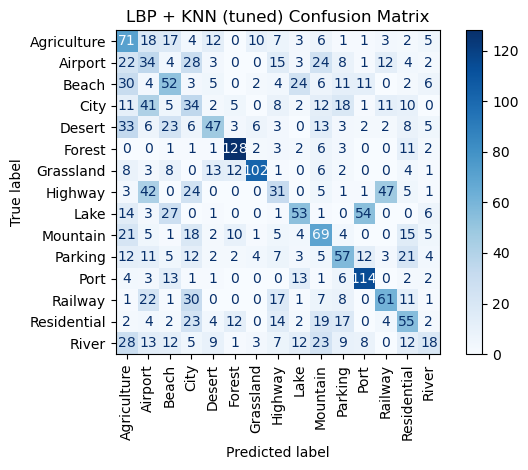

Best parameters: {'n_neighbors': 7}


In [17]:
knn_lbp = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=3, scoring='f1_weighted')
train_and_evaluate(X_train_lbp, y_train, X_test_lbp, y_test, knn_lbp, "LBP + KNN (tuned)")
print("Best parameters:", knn_lbp.best_params_)

## 6. Performance indicator bar graph for four models

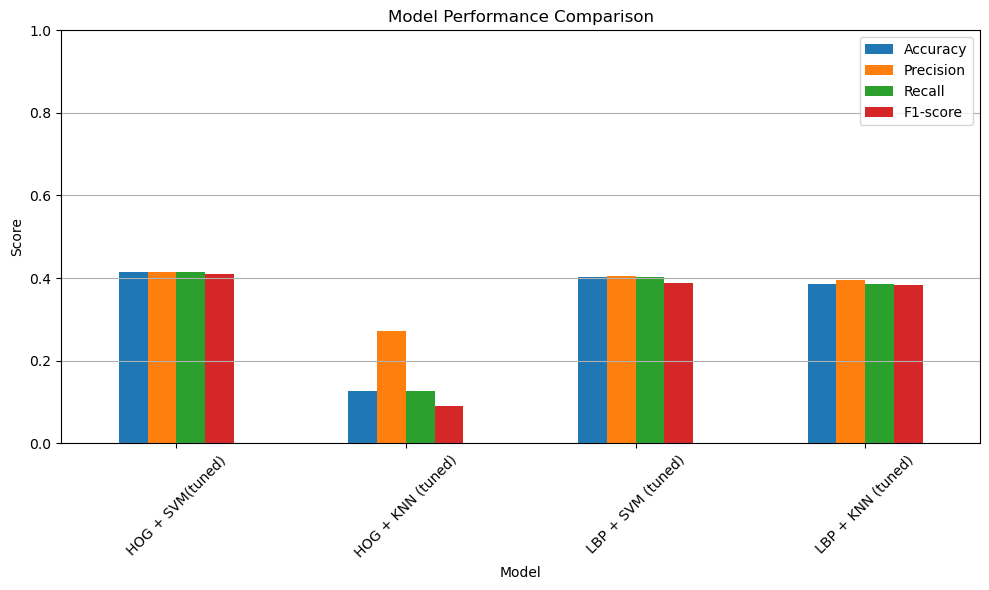

In [19]:
df_results = pd.DataFrame(results)
df_results.set_index("Model", inplace=True)

df_results.plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Save the best performing model

In [32]:
# best model
best_model_entry = max(results, key=lambda x: x["F1-score"])
print("Best model:", best_model_entry["Model"])

# save model object
import joblib
if "HOG" in best_model_entry["Model"]:
    if "SVM" in best_model_entry["Model"]:
        joblib.dump(svm_hog.best_estimator_, "best_model_traditional.joblib")
    else:
        joblib.dump(knn_hog.best_estimator_, "best_model_traditional.joblib")
else:
    if "SVM" in best_model_entry["Model"]:
        joblib.dump(svm_lbp.best_estimator_, "best_model_traditional.joblib")
    else:
        joblib.dump(knn_lbp.best_estimator_, "best_model_traditional.joblib")

Best model: HOG + SVM(tuned)
